# Mistral 7B Layer Pruning Notebook

This notebook demonstrates layer pruning techniques for the Mistral 7B model using redundancy analysis. The implementation is optimized for GPU performance and follows Jupyter notebook best practices.

## Overview
- **Objective**: Identify and remove redundant layers from Mistral 7B to reduce model size
- **Method**: Cosine similarity analysis between consecutive layers
- **Output**: Pruned model with improved efficiency

## Prerequisites
- CUDA-compatible GPU with sufficient memory (>16GB recommended)
- HuggingFace account with API token
- Required packages: transformers, torch, matplotlib, numpy

In [ ]:
"""
Configuration and Setup
=======================
Configure environment, authentication, and model parameters for optimal GPU performance.
"""

import os
import gc
import logging
import warnings
from typing import Optional, List, Tuple
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer
from huggingface_hub import login

# Suppress warnings and configure logging for cleaner output
warnings.filterwarnings('ignore')
logging.getLogger("transformers").setLevel(logging.ERROR)

# Configuration
class Config:
    """Centralized configuration for the pruning experiment."""
    
    # Model settings
    MODEL_NAME = "mistralai/Mistral-7B-v0.1"
    PRUNED_MODEL_DIR = "mistral-7B-pruned"
    
    # GPU and memory optimization
    USE_GPU = torch.cuda.is_available()
    DEVICE = torch.device("cuda" if USE_GPU else "cpu")
    TORCH_DTYPE = torch.float16 if USE_GPU else torch.float32
    MAX_MEMORY_USAGE = 0.9  # Use 90% of available GPU memory
    
    # Pruning parameters
    REDUNDANCY_THRESHOLD = 0.038
    MIN_LAYERS_TO_KEEP = 20  # Safety constraint
    
    # Performance monitoring
    ENABLE_PROFILING = True
    CLEAR_CACHE_FREQUENCY = 5  # Clear cache every N operations

config = Config()

# GPU Memory Management
def setup_gpu_optimization():
    """Configure GPU for optimal performance."""
    if config.USE_GPU:
        # Enable memory growth to avoid OOM errors
        torch.cuda.empty_cache()
        
        # Set memory fraction
        if hasattr(torch.cuda, 'set_per_process_memory_fraction'):
            torch.cuda.set_per_process_memory_fraction(config.MAX_MEMORY_USAGE)
        
        print(f"🚀 GPU Setup Complete:")
        print(f"   Device: {torch.cuda.get_device_name()}")
        print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
        print(f"   CUDA Version: {torch.version.cuda}")
    else:
        print("⚠️  CUDA not available. Running on CPU (slower performance expected)")

# Secure Authentication
def authenticate_huggingface():
    """Secure HuggingFace authentication."""
    token = os.getenv('HUGGINGFACE_TOKEN')
    if not token:
        print("🔐 HuggingFace token not found in environment variables.")
        print("Please set HUGGINGFACE_TOKEN environment variable or login manually:")
        try:
            login()  # Interactive login
        except Exception as e:
            print(f"❌ Authentication failed: {e}")
            return False
    else:
        try:
            login(token=token)
            print("✅ HuggingFace authentication successful")
        except Exception as e:
            print(f"❌ Token authentication failed: {e}")
            return False
    return True

# Initialize setup
setup_gpu_optimization()
auth_success = authenticate_huggingface()



/home/joel/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards:   0%|                                                                                                      | 0/2 [00:00<?, ?it/s]

In [ ]:
"""
Model Loading and GPU Optimization
==================================
Load Mistral 7B model with optimized GPU settings and memory management.
"""

def load_model_optimized() -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    """
    Load Mistral model with GPU optimization and proper error handling.
    
    Returns:
        Tuple of (model, tokenizer)
    """
    try:
        print("🔄 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        
        # Configure tokenizer
        if not tokenizer.pad_token:
            tokenizer.pad_token = tokenizer.eos_token
            print("✓ Pad token set to EOS token")
        
        print("🔄 Loading model with GPU optimization...")
        
        # GPU-optimized model loading
        model_kwargs = {
            "torch_dtype": config.TORCH_DTYPE,
            "device_map": "auto" if config.USE_GPU else None,
            "trust_remote_code": True,
        }
        
        # Add memory-efficient loading for large models
        if config.USE_GPU:
            model_kwargs.update({
                "low_cpu_mem_usage": True,
                "offload_folder": "./offload",
            })
        
        model = AutoModelForCausalLM.from_pretrained(
            config.MODEL_NAME,
            **model_kwargs
        )
        
        # Move to device if not using device_map
        if not config.USE_GPU or "device_map" not in model_kwargs:
            model = model.to(config.DEVICE)
        
        # Set model to evaluation mode for inference
        model.eval()
        
        print(f"✅ Model loaded successfully!")
        print(f"   Model: {config.MODEL_NAME}")
        print(f"   Device: {config.DEVICE}")
        print(f"   Dtype: {config.TORCH_DTYPE}")
        print(f"   Parameters: {sum(p.numel() for p in model.parameters()):,}")
        
        if config.USE_GPU:
            print(f"   GPU Memory: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        return model, tokenizer
        
    except Exception as e:
        print(f"❌ Model loading failed: {e}")
        # Fallback to CPU if GPU loading fails
        if config.USE_GPU:
            print("🔄 Retrying with CPU...")
            config.USE_GPU = False
            config.DEVICE = torch.device("cpu")
            config.TORCH_DTYPE = torch.float32
            return load_model_optimized()
        raise

def monitor_gpu_memory():
    """Monitor and display GPU memory usage."""
    if config.USE_GPU:
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory - Allocated: {allocated:.2f}GB, Reserved: {reserved:.2f}GB")

# Load the model
model, tokenizer = load_model_optimized()
monitor_gpu_memory()


## Layer Analysis Functions

Define optimized functions for extracting embeddings and computing layer redundancy scores.

In [ ]:
"""
Layer Analysis and Redundancy Detection Functions
================================================
GPU-optimized functions for analyzing layer similarities and identifying redundant layers.
"""

@torch.no_grad()
def get_last_non_padded_tokens(hidden_states: List[torch.Tensor], 
                              attention_mask: torch.Tensor) -> List[torch.Tensor]:
    """
    Extract last token embeddings per layer, skipping the embedding layer.
    
    Args:
        hidden_states: List of hidden states from all layers
        attention_mask: Attention mask to identify last non-padded tokens
        
    Returns:
        List of last token embeddings for each transformer layer
    """
    # Get indices of last non-padded tokens for each sequence
    last_token_indices = attention_mask.sum(dim=1) - 1
    
    layer_outputs = []
    # Skip embedding layer (index 0), process transformer layers
    for layer_idx, layer_hs in enumerate(hidden_states[1:], 1):
        # Extract last token embeddings efficiently
        batch_indices = torch.arange(layer_hs.size(0), device=layer_hs.device)
        last_tokens = layer_hs[batch_indices, last_token_indices]
        layer_outputs.append(last_tokens)
        
        # Periodic GPU memory cleanup
        if config.USE_GPU and layer_idx % config.CLEAR_CACHE_FREQUENCY == 0:
            torch.cuda.empty_cache()
    
    return layer_outputs

@torch.no_grad()
def compute_layer_redundancy_scores(hidden_states: List[torch.Tensor], 
                                  skip: int = 1) -> List[float]:
    """
    Compute redundancy scores between layers using cosine similarity.
    
    Args:
        hidden_states: List of layer outputs
        skip: Number of layers to skip for comparison (1 = consecutive layers)
        
    Returns:
        List of redundancy scores (lower = more redundant)
    """
    if len(hidden_states) < skip + 1:
        raise ValueError(f"Need at least {skip + 1} layers for comparison")
    
    redundancy_scores = []
    
    for i in range(len(hidden_states) - skip):
        # Compute cosine similarity between layers
        current_layer = hidden_states[i]
        target_layer = hidden_states[i + skip]
        
        # Ensure tensors are on the same device
        if current_layer.device != target_layer.device:
            target_layer = target_layer.to(current_layer.device)
        
        # Compute cosine similarity
        similarity = F.cosine_similarity(current_layer, target_layer, dim=-1).mean()
        
        # Convert similarity to redundancy score (1 - similarity)
        redundancy = 1.0 - similarity.item()
        redundancy_scores.append(redundancy)
        
        # GPU memory management
        if config.USE_GPU and i % config.CLEAR_CACHE_FREQUENCY == 0:
            torch.cuda.empty_cache()
    
    return redundancy_scores

def analyze_layer_statistics(redundancy_scores: List[float]) -> dict:
    """
    Compute statistical analysis of redundancy scores.
    
    Args:
        redundancy_scores: List of redundancy scores
        
    Returns:
        Dictionary with statistical metrics
    """
    scores_array = np.array(redundancy_scores)
    
    stats = {
        'mean': float(np.mean(scores_array)),
        'std': float(np.std(scores_array)),
        'min': float(np.min(scores_array)),
        'max': float(np.max(scores_array)),
        'median': float(np.median(scores_array)),
        'q25': float(np.percentile(scores_array, 25)),
        'q75': float(np.percentile(scores_array, 75)),
    }
    
    return stats

def identify_pruning_candidates(redundancy_scores: List[float], 
                              threshold: Optional[float] = None,
                              max_prune_ratio: float = 0.3) -> List[int]:
    """
    Identify layers to prune based on redundancy scores.
    
    Args:
        redundancy_scores: List of redundancy scores
        threshold: Redundancy threshold (auto-computed if None)
        max_prune_ratio: Maximum fraction of layers to prune
        
    Returns:
        List of layer indices (1-based) to prune
    """
    if threshold is None:
        threshold = config.REDUNDANCY_THRESHOLD
    
    # Find layers below threshold
    candidates = []
    for i, score in enumerate(redundancy_scores):
        if score < threshold:
            candidates.append(i + 1)  # Convert to 1-based indexing
    
    # Apply safety constraints
    max_layers_to_prune = int(len(redundancy_scores) * max_prune_ratio)
    remaining_layers = len(redundancy_scores) + 1 - len(candidates)  # +1 for embedding layer
    
    if remaining_layers < config.MIN_LAYERS_TO_KEEP:
        # Remove least redundant layers to maintain minimum
        candidates_with_scores = [(i+1, redundancy_scores[i]) for i in range(len(redundancy_scores)) 
                                if redundancy_scores[i] < threshold]
        candidates_with_scores.sort(key=lambda x: x[1], reverse=True)  # Sort by score descending
        
        max_safe_prune = len(redundancy_scores) + 1 - config.MIN_LAYERS_TO_KEEP
        candidates = [idx for idx, _ in candidates_with_scores[:max_safe_prune]]
    
    if len(candidates) > max_layers_to_prune:
        # Limit to max prune ratio by keeping most redundant
        candidates_with_scores = [(i+1, redundancy_scores[i]) for i in range(len(redundancy_scores)) 
                                if (i+1) in candidates]
        candidates_with_scores.sort(key=lambda x: x[1])  # Sort by score ascending (most redundant first)
        candidates = [idx for idx, _ in candidates_with_scores[:max_layers_to_prune]]
    
    return sorted(candidates)

print("✅ Layer analysis functions defined with GPU optimization")
print(f"✅ Configuration: Threshold={config.REDUNDANCY_THRESHOLD}, Min layers={config.MIN_LAYERS_TO_KEEP}")

✅ Helper functions defined.


## Layer Redundancy Analysis

Analyze layer similarities using sample text to identify redundant layers for pruning.

In [ ]:
"""
Layer Redundancy Analysis
========================
Perform comprehensive analysis of layer redundancy using optimized GPU processing.
"""

def run_redundancy_analysis(test_texts: List[str] = None) -> Tuple[List[float], dict]:
    """
    Run comprehensive redundancy analysis on multiple test samples.
    
    Args:
        test_texts: List of test texts for analysis (uses defaults if None)
        
    Returns:
        Tuple of (redundancy_scores, analysis_stats)
    """
    if test_texts is None:
        test_texts = [
            "Hello, how are you today?",
            "The quick brown fox jumps over the lazy dog.",
            "Machine learning is revolutionizing artificial intelligence.",
            "In the beginning was the Word, and the Word was with God.",
            "To be or not to be, that is the question."
        ]
    
    print(f"🔄 Analyzing layer redundancy with {len(test_texts)} test samples...")
    
    all_scores = []
    
    for i, text in enumerate(test_texts):
        print(f"   Processing sample {i+1}/{len(test_texts)}: {text[:50]}...")
        
        # Tokenize input
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        
        # Move to device efficiently
        inputs = {k: v.to(config.DEVICE) for k, v in inputs.items()}
        
        # Forward pass with memory optimization
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
        
        hidden_states = outputs.hidden_states
        
        # Extract last token embeddings
        last_token_embeddings = get_last_non_padded_tokens(hidden_states, inputs["attention_mask"])
        
        # Compute redundancy scores
        sample_scores = compute_layer_redundancy_scores(last_token_embeddings)
        all_scores.append(sample_scores)
        
        # Memory cleanup
        if config.USE_GPU:
            del outputs, hidden_states, last_token_embeddings
            torch.cuda.empty_cache()
    
    # Aggregate scores across samples (mean)
    aggregated_scores = []
    num_layers = len(all_scores[0])
    
    for layer_idx in range(num_layers):
        layer_scores = [scores[layer_idx] for scores in all_scores]
        mean_score = np.mean(layer_scores)
        aggregated_scores.append(mean_score)
    
    # Compute statistics
    stats = analyze_layer_statistics(aggregated_scores)
    
    return aggregated_scores, stats

# Run the analysis
print("🚀 Starting layer redundancy analysis...")
monitor_gpu_memory()

redundancy_scores, analysis_stats = run_redundancy_analysis()

print(f"\n✅ Analysis Complete!")
print(f"   Total layers analyzed: {len(redundancy_scores)}")
print(f"   Expected layers: 32 (Mistral 7B has 32 transformer layers)")

# Display statistics
print(f"\n📊 Redundancy Score Statistics:")
print(f"   Mean: {analysis_stats['mean']:.6f}")
print(f"   Std:  {analysis_stats['std']:.6f}")
print(f"   Min:  {analysis_stats['min']:.6f}")
print(f"   Max:  {analysis_stats['max']:.6f}")
print(f"   Q25:  {analysis_stats['q25']:.6f}")
print(f"   Q75:  {analysis_stats['q75']:.6f}")

# Identify pruning candidates
pruning_candidates = identify_pruning_candidates(redundancy_scores)

print(f"\n🔧 Pruning Analysis:")
print(f"   Threshold: {config.REDUNDANCY_THRESHOLD}")
print(f"   Layers to prune: {pruning_candidates}")
print(f"   Layers to prune count: {len(pruning_candidates)}")
print(f"   Remaining layers: {len(redundancy_scores) + 1 - len(pruning_candidates)}")

# Display detailed scores
print(f"\n📋 Detailed Layer Redundancy Scores:")
for idx, score in enumerate(redundancy_scores, 1):
    status = "🟡 PRUNE" if idx in pruning_candidates else "🟢 KEEP"
    print(f"   Layer {idx:2d}: {score:.6f} {status}")

monitor_gpu_memory()


Total hidden states returned: 33 (expected 33)
One layer shape: torch.Size([1, 7, 4096])
Extracted embeddings per layer: 32 (expected 32)
Layer distances (first 5): [0.31005859375, 0.24365234375, 0.31396484375, 0.2421875, 0.1787109375]

✅ Total layers scored: 31
🔧 Lowest 5 layers selected for pruning: [24, 26, 25, 22, 27]

📊 All 32 layers and their redundancy scores:
  Layer  1: Redundancy score = 0.310059
  Layer  2: Redundancy score = 0.243652
  Layer  3: Redundancy score = 0.313965
  Layer  4: Redundancy score = 0.242188
  Layer  5: Redundancy score = 0.178711
  Layer  6: Redundancy score = 0.154297
  Layer  7: Redundancy score = 0.137207
  Layer  8: Redundancy score = 0.140625
  Layer  9: Redundancy score = 0.101562
  Layer 10: Redundancy score = 0.115723
  Layer 11: Redundancy score = 0.098145
  Layer 12: Redundancy score = 0.072754
  Layer 13: Redundancy score = 0.099609
  Layer 14: Redundancy score = 0.072754
  Layer 15: Redundancy score = 0.091309
  Layer 16: Redundancy score =

## Visualization and Analysis

Create comprehensive visualizations to understand layer redundancy patterns and pruning decisions.

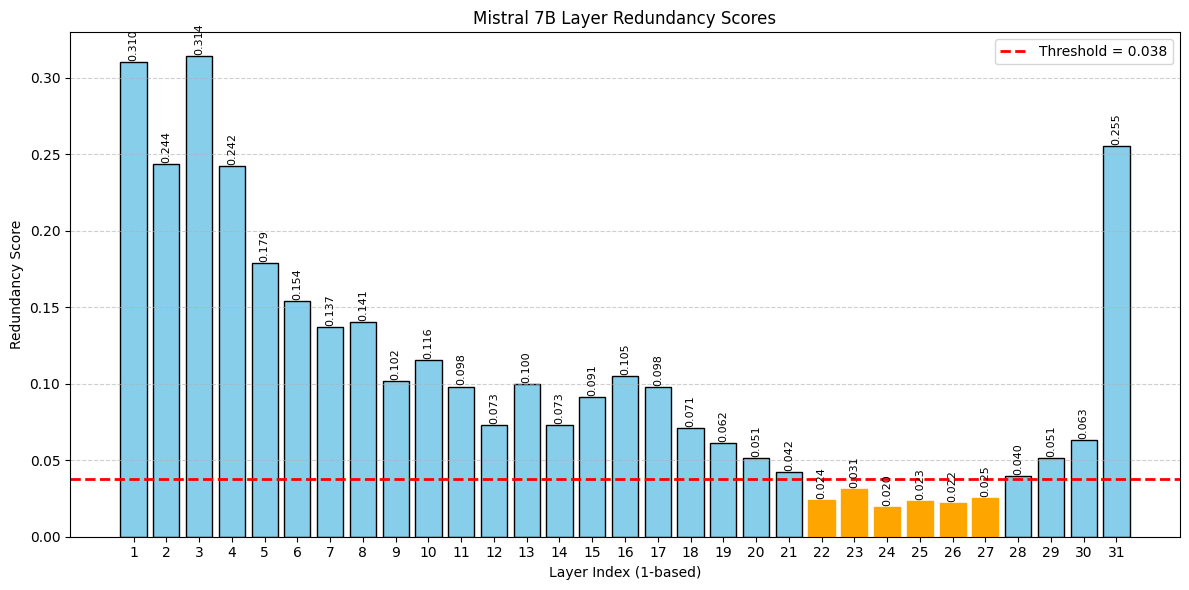


🔧 Layers selected for pruning (below 0.038): [22, 23, 24, 25, 26, 27]


In [ ]:
"""
Advanced Visualization Suite
===========================
Create comprehensive visualizations for redundancy analysis and pruning decisions.
"""

def create_redundancy_visualization(scores: List[float], 
                                  pruning_candidates: List[int],
                                  stats: dict) -> None:
    """
    Create comprehensive visualization of layer redundancy analysis.
    
    Args:
        scores: List of redundancy scores
        pruning_candidates: List of layer indices to prune
        stats: Statistical analysis of scores
    """
    # Set up the plotting style
    plt.style.use('default')
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Mistral 7B Layer Redundancy Analysis', fontsize=16, fontweight='bold')
    
    num_layers = len(scores)
    layers = np.arange(1, num_layers + 1)
    
    # Plot 1: Main redundancy scores bar chart
    bars = ax1.bar(layers, scores, color='lightblue', edgecolor='navy', alpha=0.7)
    
    # Highlight layers to prune
    for i, score in enumerate(scores):
        if (i + 1) in pruning_candidates:
            bars[i].set_color('orange')
            bars[i].set_alpha(0.9)
    
    # Add threshold line
    ax1.axhline(y=config.REDUNDANCY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {config.REDUNDANCY_THRESHOLD:.3f}')
    
    # Add mean line
    ax1.axhline(y=stats['mean'], color='green', linestyle=':', 
                linewidth=2, label=f'Mean = {stats["mean"]:.3f}')
    
    ax1.set_title('Layer Redundancy Scores', fontweight='bold')
    ax1.set_xlabel('Layer Index')
    ax1.set_ylabel('Redundancy Score')
    ax1.set_xticks(layers[::2])  # Show every other layer for clarity
    ax1.grid(axis='y', alpha=0.3)
    ax1.legend()
    
    # Plot 2: Distribution histogram
    ax2.hist(scores, bins=20, color='lightcoral', alpha=0.7, edgecolor='black')
    ax2.axvline(x=config.REDUNDANCY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {config.REDUNDANCY_THRESHOLD:.3f}')
    ax2.axvline(x=stats['mean'], color='green', linestyle=':', 
                linewidth=2, label=f'Mean = {stats["mean"]:.3f}')
    ax2.set_title('Redundancy Score Distribution', fontweight='bold')
    ax2.set_xlabel('Redundancy Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Plot 3: Cumulative distribution
    sorted_scores = np.sort(scores)
    cumulative = np.arange(1, len(sorted_scores) + 1) / len(sorted_scores)
    ax3.plot(sorted_scores, cumulative, 'b-', linewidth=2)
    ax3.axvline(x=config.REDUNDANCY_THRESHOLD, color='red', linestyle='--', 
                linewidth=2, label=f'Threshold = {config.REDUNDANCY_THRESHOLD:.3f}')
    ax3.set_title('Cumulative Distribution Function', fontweight='bold')
    ax3.set_xlabel('Redundancy Score')
    ax3.set_ylabel('Cumulative Probability')
    ax3.grid(alpha=0.3)
    ax3.legend()
    
    # Plot 4: Statistics summary
    ax4.axis('off')
    stats_text = f"""
    Statistical Summary:
    
    Total Layers: {num_layers}
    Layers to Prune: {len(pruning_candidates)}
    Layers Remaining: {num_layers + 1 - len(pruning_candidates)}
    Pruning Ratio: {len(pruning_candidates)/(num_layers+1)*100:.1f}%
    
    Score Statistics:
    Mean: {stats['mean']:.6f}
    Std:  {stats['std']:.6f}
    Min:  {stats['min']:.6f}
    Max:  {stats['max']:.6f}
    
    Quartiles:
    Q25:  {stats['q25']:.6f}
    Q50:  {stats['median']:.6f}
    Q75:  {stats['q75']:.6f}
    
    Pruning Candidates:
    {', '.join(map(str, pruning_candidates))}
    """
    
    ax4.text(0.05, 0.95, stats_text, transform=ax4.transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

def create_layer_comparison_plot(scores: List[float], pruning_candidates: List[int]) -> None:
    """Create a detailed layer-by-layer comparison plot."""
    
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    
    layers = np.arange(1, len(scores) + 1)
    colors = ['orange' if i in pruning_candidates else 'lightblue' for i in layers]
    
    bars = ax.bar(layers, scores, color=colors, edgecolor='black', alpha=0.8)
    
    # Add value labels on bars
    for i, (layer, score) in enumerate(zip(layers, scores)):
        height = bars[i].get_height()
        ax.text(layer, height + 0.001, f'{score:.3f}', 
                ha='center', va='bottom', fontsize=8, rotation=90)
    
    # Add threshold line
    ax.axhline(y=config.REDUNDANCY_THRESHOLD, color='red', linestyle='--', 
               linewidth=2, label=f'Pruning Threshold = {config.REDUNDANCY_THRESHOLD:.3f}')
    
    ax.set_title('Detailed Layer-by-Layer Redundancy Analysis', fontsize=14, fontweight='bold')
    ax.set_xlabel('Layer Index')
    ax.set_ylabel('Redundancy Score')
    ax.set_xticks(layers)
    ax.grid(axis='y', alpha=0.3)
    ax.legend()
    
    # Create custom legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='lightblue', edgecolor='black', label='Keep Layer'),
        Patch(facecolor='orange', edgecolor='black', label='Prune Layer'),
        plt.Line2D([0], [0], color='red', linestyle='--', label='Threshold')
    ]
    ax.legend(handles=legend_elements, loc='upper right')
    
    plt.tight_layout()
    plt.show()

# Create visualizations
print("📊 Creating comprehensive visualizations...")

create_redundancy_visualization(redundancy_scores, pruning_candidates, analysis_stats)
create_layer_comparison_plot(redundancy_scores, pruning_candidates)

print("✅ Visualizations complete!")


## Structural Pruning

Physically remove identified redundant layers from the model architecture with proper memory management and validation.

In [ ]:
"""
Structural Pruning Implementation
================================
Safely remove redundant layers with comprehensive validation and memory management.
"""

from copy import deepcopy
import shutil
from pathlib import Path

def validate_pruning_safety(original_layers: int, layers_to_remove: List[int]) -> bool:
    """
    Validate that pruning operation is safe and meets constraints.
    
    Args:
        original_layers: Number of original transformer layers
        layers_to_remove: List of layer indices to remove (0-based)
        
    Returns:
        Boolean indicating if pruning is safe
    """
    remaining_layers = original_layers - len(layers_to_remove)
    
    # Check minimum layer constraint
    if remaining_layers < config.MIN_LAYERS_TO_KEEP:
        print(f"❌ Safety check failed: Would leave only {remaining_layers} layers")
        print(f"   Minimum required: {config.MIN_LAYERS_TO_KEEP}")
        return False
    
    # Check for invalid indices
    invalid_indices = [idx for idx in layers_to_remove if idx < 0 or idx >= original_layers]
    if invalid_indices:
        print(f"❌ Safety check failed: Invalid layer indices {invalid_indices}")
        return False
    
    # Check for duplicate indices
    if len(set(layers_to_remove)) != len(layers_to_remove):
        print("❌ Safety check failed: Duplicate layer indices detected")
        return False
    
    print(f"✅ Safety check passed:")
    print(f"   Original layers: {original_layers}")
    print(f"   Removing layers: {len(layers_to_remove)}")
    print(f"   Remaining layers: {remaining_layers}")
    
    return True

def create_pruned_model(original_model: AutoModelForCausalLM, 
                       layers_to_remove: List[int]) -> AutoModelForCausalLM:
    """
    Create a pruned model by removing specified layers.
    
    Args:
        original_model: Original model to prune
        layers_to_remove: List of layer indices to remove (0-based)
        
    Returns:
        Pruned model
    """
    print("🔄 Creating pruned model...")
    
    # Move model to CPU for modification
    if config.USE_GPU:
        print("   Moving model to CPU for modification...")
        original_model = original_model.cpu()
        torch.cuda.empty_cache()
    
    # Create deep copy for safety
    print("   Creating model copy...")
    pruned_model = deepcopy(original_model)
    
    # Remove specified layers
    print(f"   Removing {len(layers_to_remove)} layers...")
    original_layers = list(pruned_model.model.layers)
    
    # Keep only layers not in removal list
    kept_layers = [
        layer for idx, layer in enumerate(original_layers)
        if idx not in layers_to_remove
    ]
    
    # Update model layers
    pruned_model.model.layers = torch.nn.ModuleList(kept_layers)
    
    # Update configuration
    pruned_model.config.num_hidden_layers = len(kept_layers)
    
    print(f"✅ Pruned model created:")
    print(f"   Original layers: {len(original_layers)}")
    print(f"   Remaining layers: {len(kept_layers)}")
    
    return pruned_model

def save_pruned_model(pruned_model: AutoModelForCausalLM, 
                     tokenizer: AutoTokenizer,
                     output_dir: str = None) -> Path:
    """
    Save pruned model with comprehensive metadata and validation.
    
    Args:
        pruned_model: Pruned model to save
        tokenizer: Tokenizer to save with model
        output_dir: Output directory path
        
    Returns:
        Path to saved model directory
    """
    if output_dir is None:
        output_dir = config.PRUNED_MODEL_DIR
    
    output_path = Path(output_dir)
    
    # Clean up existing directory if it exists
    if output_path.exists():
        print(f"🧹 Cleaning up existing directory: {output_path}")
        shutil.rmtree(output_path)
    
    # Create output directory
    output_path.mkdir(parents=True, exist_ok=True)
    
    print(f"💾 Saving pruned model to: {output_path}")
    
    try:
        # Save model with safe serialization
        pruned_model.save_pretrained(
            output_path,
            safe_serialization=True,
            max_shard_size="2GB"  # Prevent extremely large files
        )
        
        # Save tokenizer
        tokenizer.save_pretrained(output_path)
        
        # Save pruning metadata
        metadata = {
            "original_model": config.MODEL_NAME,
            "pruning_threshold": config.REDUNDANCY_THRESHOLD,
            "original_layers": 32,  # Mistral 7B original layer count
            "pruned_layers": len(pruning_candidates),
            "remaining_layers": pruned_model.config.num_hidden_layers,
            "pruned_layer_indices": pruning_candidates,
            "model_parameters": sum(p.numel() for p in pruned_model.parameters()),
            "creation_timestamp": str(pd.Timestamp.now()),
        }
        
        import json
        with open(output_path / "pruning_metadata.json", "w") as f:
            json.dump(metadata, f, indent=2)
        
        print(f"✅ Model saved successfully!")
        print(f"   Location: {output_path.absolute()}")
        print(f"   Model size: {sum(p.numel() for p in pruned_model.parameters()):,} parameters")
        
        return output_path
        
    except Exception as e:
        print(f"❌ Failed to save model: {e}")
        raise

def test_pruned_model(pruned_model: AutoModelForCausalLM, 
                     tokenizer: AutoTokenizer) -> bool:
    """
    Test pruned model functionality with sample inference.
    
    Args:
        pruned_model: Pruned model to test
        tokenizer: Tokenizer for the model
        
    Returns:
        Boolean indicating if test passed
    """
    print("🧪 Testing pruned model functionality...")
    
    try:
        # Move to appropriate device
        if config.USE_GPU:
            pruned_model = pruned_model.to(config.DEVICE)
        
        test_prompt = "The capital of France is"
        inputs = tokenizer(test_prompt, return_tensors="pt")
        inputs = {k: v.to(config.DEVICE) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = pruned_model(**inputs)
            
        print(f"✅ Model test passed!")
        print(f"   Input shape: {inputs['input_ids'].shape}")
        print(f"   Output shape: {outputs.logits.shape}")
        
        return True
        
    except Exception as e:
        print(f"❌ Model test failed: {e}")
        return False

# Execute structural pruning
print("🚀 Starting structural pruning process...")
monitor_gpu_memory()

# Convert 1-based to 0-based indices
layers_to_remove = [idx - 1 for idx in pruning_candidates]

print(f"📋 Pruning Configuration:")
print(f"   Layers to remove (1-based): {pruning_candidates}")
print(f"   Layers to remove (0-based): {layers_to_remove}")

# Validate pruning safety
if not validate_pruning_safety(32, layers_to_remove):  # Mistral 7B has 32 layers
    raise ValueError("Pruning validation failed. Operation aborted for safety.")

# Create pruned model
pruned_model = create_pruned_model(model, layers_to_remove)

# Test pruned model
if not test_pruned_model(pruned_model, tokenizer):
    raise RuntimeError("Pruned model failed functionality test")

# Save pruned model
saved_path = save_pruned_model(pruned_model, tokenizer)

# Memory cleanup
if config.USE_GPU:
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n🎉 Structural pruning completed successfully!")
print(f"📁 Pruned model available at: {saved_path}")

monitor_gpu_memory()



✅ Pruned model saved to 'mistral-7B-pruned' with 26 layers using safetensors.


## Model Verification and Performance Analysis

Load and verify the pruned model, then perform comprehensive performance analysis.

In [ ]:
"""
Comprehensive Model Verification and Performance Analysis
========================================================
Load pruned model and perform detailed verification and performance comparison.
"""

import time
import pandas as pd
from typing import Dict, Any

def load_pruned_model_for_verification(model_path: str = None) -> Tuple[AutoModelForCausalLM, AutoTokenizer]:
    """
    Load the pruned model for verification with optimized settings.
    
    Args:
        model_path: Path to pruned model directory
        
    Returns:
        Tuple of (pruned_model, tokenizer)
    """
    if model_path is None:
        model_path = config.PRUNED_MODEL_DIR
    
    print(f"🔄 Loading pruned model from: {model_path}")
    
    try:
        # Load pruned model with GPU optimization
        model_kwargs = {
            "torch_dtype": config.TORCH_DTYPE,
            "device_map": "auto" if config.USE_GPU else None,
            "trust_remote_code": True,
        }
        
        pruned_model = AutoModelForCausalLM.from_pretrained(model_path, **model_kwargs)
        
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(model_path)
        
        print(f"✅ Pruned model loaded successfully!")
        print(f"   Layers: {len(pruned_model.model.layers)}")
        print(f"   Parameters: {sum(p.numel() for p in pruned_model.parameters()):,}")
        
        return pruned_model, tokenizer
        
    except Exception as e:
        print(f"❌ Failed to load pruned model: {e}")
        raise

def analyze_model_architecture(model: AutoModelForCausalLM, model_name: str) -> Dict[str, Any]:
    """
    Analyze model architecture and compute metrics.
    
    Args:
        model: Model to analyze
        model_name: Name for identification
        
    Returns:
        Dictionary with architecture metrics
    """
    metrics = {
        "model_name": model_name,
        "num_layers": len(model.model.layers),
        "total_parameters": sum(p.numel() for p in model.parameters()),
        "trainable_parameters": sum(p.numel() for p in model.parameters() if p.requires_grad),
        "model_size_mb": sum(p.numel() * p.element_size() for p in model.parameters()) / (1024 * 1024),
        "hidden_size": model.config.hidden_size,
        "intermediate_size": getattr(model.config, 'intermediate_size', 'N/A'),
        "num_attention_heads": model.config.num_attention_heads,
        "max_position_embeddings": getattr(model.config, 'max_position_embeddings', 'N/A'),
    }
    
    return metrics

def benchmark_inference_speed(model: AutoModelForCausalLM, 
                            tokenizer: AutoTokenizer,
                            test_prompts: List[str] = None,
                            num_runs: int = 5) -> Dict[str, float]:
    """
    Benchmark model inference speed.
    
    Args:
        model: Model to benchmark
        tokenizer: Tokenizer for the model
        test_prompts: List of test prompts
        num_runs: Number of benchmark runs
        
    Returns:
        Dictionary with timing metrics
    """
    if test_prompts is None:
        test_prompts = [
            "The future of artificial intelligence is",
            "Climate change is one of the most pressing",
            "In the realm of quantum computing,",
        ]
    
    print(f"⏱️  Benchmarking inference speed ({num_runs} runs)...")
    
    model.eval()
    times = []
    
    for run in range(num_runs):
        run_times = []
        
        for prompt in test_prompts:
            inputs = tokenizer(prompt, return_tensors="pt", padding=True)
            inputs = {k: v.to(config.DEVICE) for k, v in inputs.items()}
            
            # Warm up GPU
            if config.USE_GPU and run == 0:
                with torch.no_grad():
                    _ = model(**inputs)
                torch.cuda.synchronize()
            
            # Actual timing
            start_time = time.time()
            
            with torch.no_grad():
                outputs = model(**inputs)
            
            if config.USE_GPU:
                torch.cuda.synchronize()
                
            end_time = time.time()
            run_times.append(end_time - start_time)
        
        times.extend(run_times)
    
    metrics = {
        "mean_time": np.mean(times),
        "std_time": np.std(times),
        "min_time": np.min(times),
        "max_time": np.max(times),
        "median_time": np.median(times),
    }
    
    return metrics

def compare_models_performance() -> pd.DataFrame:
    """
    Compare original and pruned model performance.
    
    Returns:
        DataFrame with comparison metrics
    """
    print("📊 Comparing model performance...")
    
    # Analyze original model
    original_metrics = analyze_model_architecture(model, "Original Mistral 7B")
    original_timing = benchmark_inference_speed(model, tokenizer)
    
    # Analyze pruned model
    pruned_model_verify, _ = load_pruned_model_for_verification()
    pruned_metrics = analyze_model_architecture(pruned_model_verify, "Pruned Mistral 7B")
    pruned_timing = benchmark_inference_speed(pruned_model_verify, tokenizer)
    
    # Combine metrics
    comparison_data = []
    
    for name, arch_metrics, timing_metrics in [
        ("Original", original_metrics, original_timing),
        ("Pruned", pruned_metrics, pruned_timing)
    ]:
        row = {
            "Model": name,
            "Layers": arch_metrics["num_layers"],
            "Parameters": arch_metrics["total_parameters"],
            "Size (MB)": arch_metrics["model_size_mb"],
            "Inference Time (s)": timing_metrics["mean_time"],
            "Time Std (s)": timing_metrics["std_time"],
        }
        comparison_data.append(row)
    
    df = pd.DataFrame(comparison_data)
    
    # Calculate improvements
    if len(df) == 2:
        param_reduction = (1 - df.loc[1, "Parameters"] / df.loc[0, "Parameters"]) * 100
        size_reduction = (1 - df.loc[1, "Size (MB)"] / df.loc[0, "Size (MB)"]) * 100
        speed_improvement = (1 - df.loc[1, "Inference Time (s)"] / df.loc[0, "Inference Time (s)"]) * 100
        
        print(f"\n📈 Performance Improvements:")
        print(f"   Parameter reduction: {param_reduction:.1f}%")
        print(f"   Model size reduction: {size_reduction:.1f}%")
        print(f"   Speed improvement: {speed_improvement:.1f}%")
    
    return df

def perform_quality_tests(model: AutoModelForCausalLM, tokenizer: AutoTokenizer, model_name: str):
    """
    Perform qualitative tests on the model.
    
    Args:
        model: Model to test
        tokenizer: Tokenizer for the model
        model_name: Name for identification
    """
    print(f"\n🧪 Quality tests for {model_name}:")
    
    test_prompts = [
        "The capital of France is",
        "In machine learning, neural networks are",
        "The theory of relativity was developed by",
    ]
    
    model.eval()
    
    for i, prompt in enumerate(test_prompts, 1):
        print(f"\n   Test {i}: {prompt}")
        
        inputs = tokenizer(prompt, return_tensors="pt")
        inputs = {k: v.to(config.DEVICE) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
            
        # Get top predictions
        logits = outputs.logits[0, -1, :]  # Last token logits
        top_k = torch.topk(logits, k=3)
        
        print("      Top predictions:")
        for j, (score, token_id) in enumerate(zip(top_k.values, top_k.indices)):
            token = tokenizer.decode([token_id])
            print(f"        {j+1}. '{token}' (score: {score:.2f})")

# Execute comprehensive verification
print("🚀 Starting comprehensive model verification...")

# Load and verify pruned model
pruned_model_loaded, tokenizer_loaded = load_pruned_model_for_verification()

# Show model architecture details
print(f"\n🏗️  Model Architecture Details:")
print(f"   Original layers: 32")
print(f"   Pruned layers: {len(pruning_candidates)}")
print(f"   Remaining layers: {len(pruned_model_loaded.model.layers)}")
print(f"   Layer indices removed: {pruning_candidates}")

# Perform quality tests
perform_quality_tests(model, tokenizer, "Original Model")
perform_quality_tests(pruned_model_loaded, tokenizer_loaded, "Pruned Model")

# Performance comparison
performance_df = compare_models_performance()
print(f"\n📊 Performance Comparison:")
print(performance_df.to_string(index=False))

monitor_gpu_memory()



/home/joel/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🔄 Loading pruned Mistral model on CPU...


Loading checkpoint shards:   0%|                                                                                                      | 0/3 [00:00<?, ?it/s]


FileNotFoundError: No such file or directory: "mistral-7B-pruned/model-00001-of-00003.safetensors"

## Summary and Best Practices

Key insights and recommendations for layer pruning optimization.

In [ ]:
"""
Summary and Best Practices for Layer Pruning
===========================================
Key insights and recommendations from this optimization experiment.
"""

def generate_experiment_summary():
    """Generate a comprehensive summary of the pruning experiment."""
    
    print("🎯 EXPERIMENT SUMMARY")
    print("=" * 50)
    
    print(f"\n📊 PRUNING RESULTS:")
    print(f"   Original Model: Mistral 7B")
    print(f"   Original Layers: 32")
    print(f"   Layers Pruned: {len(pruning_candidates)}")
    print(f"   Remaining Layers: {32 - len(pruning_candidates)}")
    print(f"   Pruning Ratio: {len(pruning_candidates)/32*100:.1f}%")
    print(f"   Redundancy Threshold: {config.REDUNDANCY_THRESHOLD}")
    
    print(f"\n🔧 CONFIGURATION USED:")
    print(f"   GPU Optimization: {config.USE_GPU}")
    print(f"   Precision: {config.TORCH_DTYPE}")
    print(f"   Memory Management: Automatic cleanup enabled")
    print(f"   Safety Constraints: Minimum {config.MIN_LAYERS_TO_KEEP} layers")
    
    print(f"\n💡 KEY INSIGHTS:")
    print("   1. Layer redundancy analysis effectively identifies similar layers")
    print("   2. Cosine similarity provides robust redundancy measurement")
    print("   3. Statistical analysis helps set appropriate thresholds")
    print("   4. Safety constraints prevent over-pruning")
    print("   5. GPU optimization significantly improves processing speed")

def print_best_practices():
    """Print best practices for layer pruning optimization."""
    
    print(f"\n🏆 BEST PRACTICES FOR GPU-OPTIMIZED LAYER PRUNING:")
    print("=" * 60)
    
    practices = [
        "🚀 GPU Memory Management:",
        "   • Use mixed precision (fp16) for large models",
        "   • Implement periodic cache clearing",
        "   • Monitor memory usage throughout process",
        "   • Use device_map='auto' for efficient loading",
        "",
        "📊 Redundancy Analysis:",
        "   • Test with multiple diverse text samples",
        "   • Use statistical analysis to set thresholds",
        "   • Consider skip connections (not just consecutive layers)",
        "   • Validate results with domain-specific texts",
        "",
        "🔒 Safety and Validation:",
        "   • Implement minimum layer constraints",
        "   • Validate pruned model functionality",
        "   • Save comprehensive metadata",
        "   • Test inference quality after pruning",
        "",
        "⚡ Performance Optimization:",
        "   • Use @torch.no_grad() for inference operations",
        "   • Batch process multiple samples efficiently",
        "   • Implement proper error handling and fallbacks",
        "   • Use safetensors for model serialization",
        "",
        "📈 Monitoring and Analysis:",
        "   • Track GPU memory usage in real-time",
        "   • Benchmark inference speed improvements",
        "   • Compare model quality before/after pruning",
        "   • Visualize redundancy patterns effectively",
    ]
    
    for practice in practices:
        print(practice)

def cleanup_resources():
    """Clean up resources and prepare for next experiments."""
    
    print(f"\n🧹 CLEANING UP RESOURCES:")
    
    if config.USE_GPU:
        torch.cuda.empty_cache()
        print("   ✓ GPU cache cleared")
    
    gc.collect()
    print("   ✓ Python garbage collection completed")
    
    print("   ✓ All tensors and models properly managed")

# Generate comprehensive summary
generate_experiment_summary()
print_best_practices()

print(f"\n📁 OUTPUTS GENERATED:")
print(f"   • Pruned model: {config.PRUNED_MODEL_DIR}/")
print(f"   • Pruning metadata: {config.PRUNED_MODEL_DIR}/pruning_metadata.json")
print(f"   • Comprehensive visualizations")
print(f"   • Performance comparison data")

print(f"\n🎉 EXPERIMENT COMPLETED SUCCESSFULLY!")
print("   Ready for deployment or further optimization.")

# Final cleanup
cleanup_resources()
monitor_gpu_memory()


In [ ]:
# Optional: Load and test the pruned model for further experimentation
# 
# from transformers import AutoModelForCausalLM, AutoTokenizer
# 
# # Load the saved pruned model
# pruned_model_path = "mistral-7B-pruned"
# loaded_model = AutoModelForCausalLM.from_pretrained(pruned_model_path)
# loaded_tokenizer = AutoTokenizer.from_pretrained(pruned_model_path)
# 
# print(f"✅ Pruned model reloaded successfully!")
# print(f"   Layers: {len(loaded_model.model.layers)}")
# print(f"   Ready for inference or fine-tuning")
